In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split


from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing


from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2


from pathlib import Path
import os.path


import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import seaborn as sns


from sklearn.metrics import classification_report, confusion_matrix
import itertools


from kerastuner.tuners import RandomSearch
!pip install -q keras_tuner
import keras_tuner as kt

C:\Users\jhanu\AppData\Local\Temp\ipykernel_30148\2040541337.py:39: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


###  Get the pathes

In [3]:
train_path = "C:/Users/jhanu/Downloads/intel/seg_train/seg_train/"
test_path = "C:/Users/jhanu/Downloads/intel/seg_test/seg_test/"
pred_path = "C:/Users/jhanu/Downloads/intel/seg_pred/seg_pred/"

### Prepare Data Augmentation:

In [4]:

train_datagen = ImageDataGenerator(
    rescale=1.0/255,                
    rotation_range=20,              
    width_shift_range=0.2,          
    height_shift_range=0.2,         
    horizontal_flip=True,          
    fill_mode='nearest'            
)
test_datagen = ImageDataGenerator(rescale=1.0/255)  

In [5]:
images_size = 200
batch_size = 32

### Load the Images with a generator:

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     
    target_size=(images_size, images_size),  
    batch_size=batch_size,           
    seed=32,                        
    shuffle=True,                    
    class_mode='categorical'        
)


test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(images_size, images_size),
    batch_size = batch_size,
    class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


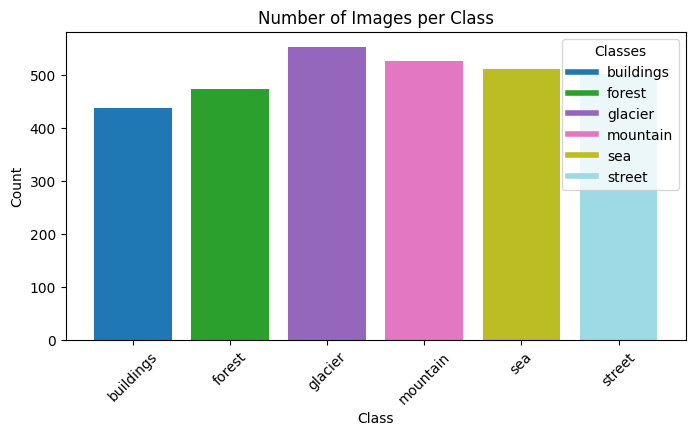

In [13]:

class_labels = list(test_generator.class_indices.keys())

class_counts = {label: 0 for label in class_labels}

for i in range(len(test_generator)):
    batch_data, batch_labels = test_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1


class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))


plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)


legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

## 📷 Visualizing images from the dataset

In [7]:
def Show_Images(target_gen):
    
    batch_images, batch_labels = next(target_gen)

    
    class_labels = list(target_gen.class_indices.keys())

    
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

### Display Train Data:

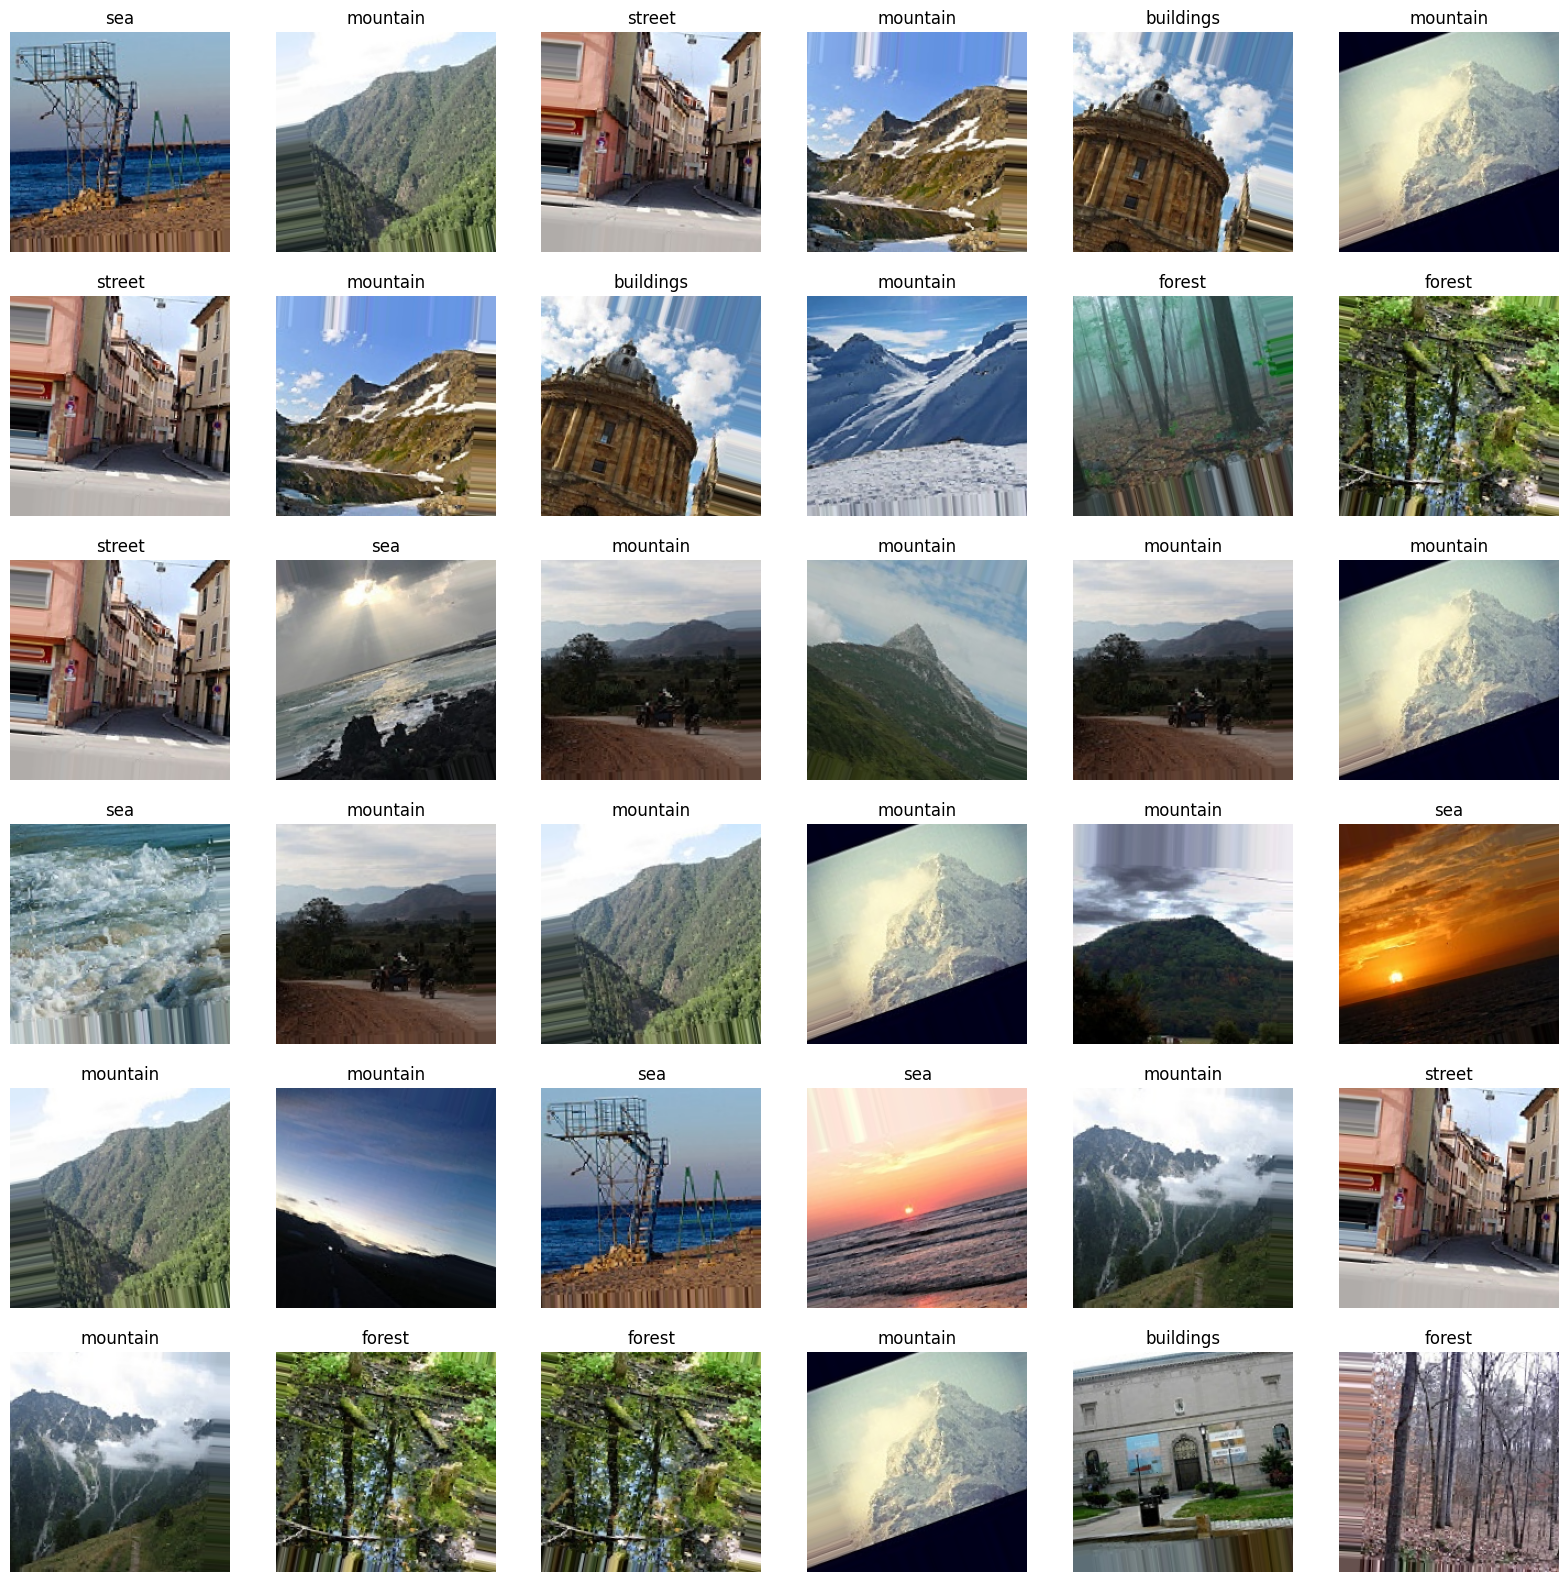

In [8]:
Show_Images(train_generator)

### Display Test Data:

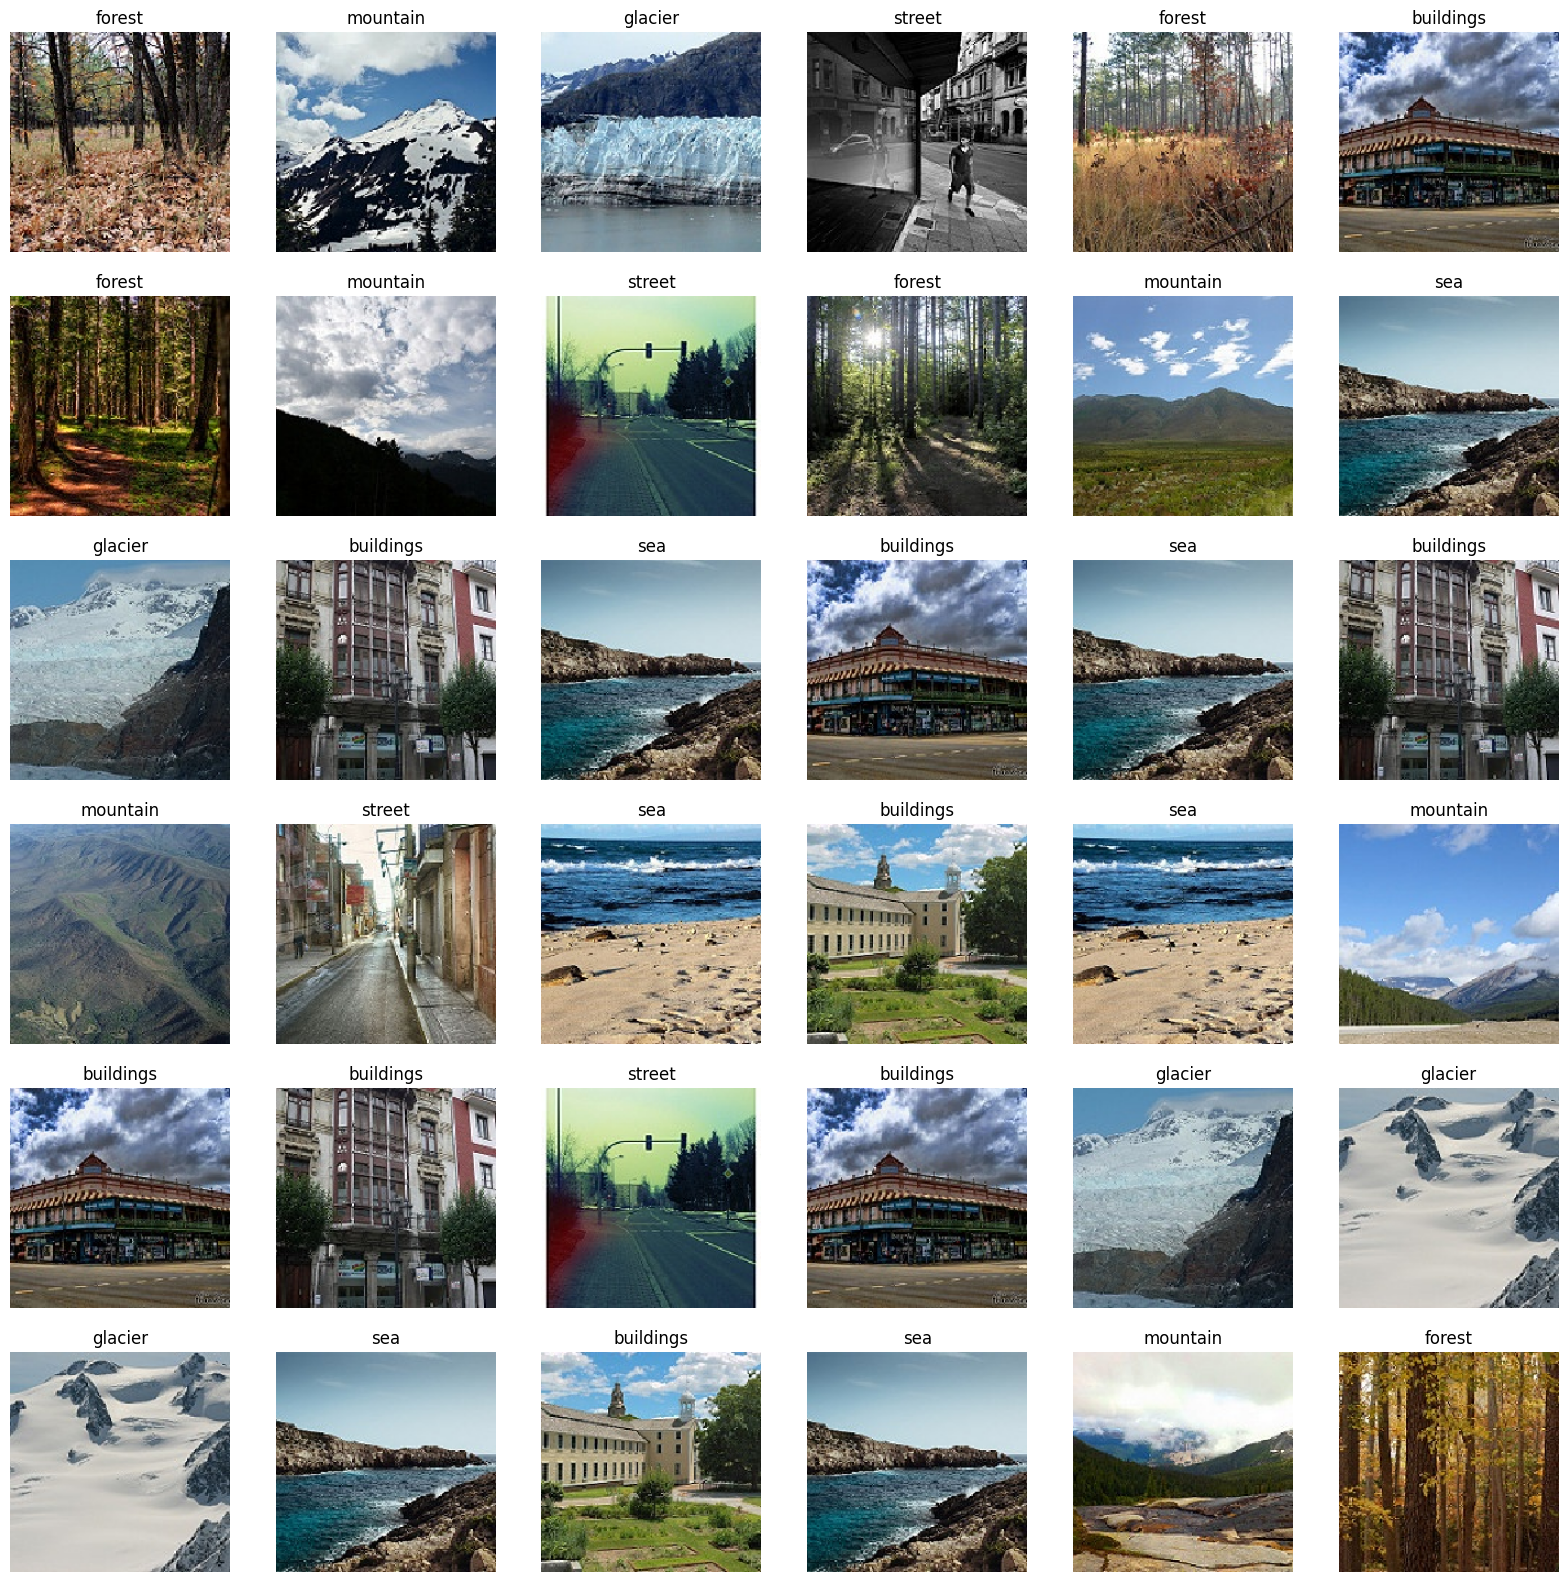

In [9]:
Show_Images(test_generator)

In [10]:
early_stopping = EarlyStopping(
    min_delta=0.001, 
    patience=5,
    restore_best_weights=True,
)

In [11]:

learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   
    patience=5,         
    verbose=1,          
    factor=0.5,         
    min_lr=0.00001       
)

In [12]:
from tensorflow.keras import optimizers


learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  
    decay_steps=1000,            
    decay_rate=0.5,              
)




### Define Callbacks:

In [13]:
from keras.callbacks import LearningRateScheduler


lr_callback = LearningRateScheduler(learning_rate_schedule)
callback=[ lr_callback , learning_rate_reduce ,early_stopping ]

In [14]:

TL_Models =[
    ResNet50V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    ResNet152V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    InceptionV3(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    Xception(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    MobileNetV2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
]


TL_Models_NAMES = [
    'ResNet50V2',
    'ResNet152V2',
    'InceptionV3',
    'Xception',
    'MobileNetV2',
]

for tl_model in TL_Models:
    tl_model.trainable = False

### Subset from training data

In [15]:

subset_images = []
subset_labels = []


desired_count = 1000


for i in range(desired_count):
    
    batch = train_generator.next()
    images, labels = batch
    subset_images.extend(images)
    subset_labels.extend(labels)


    if len(subset_images) >= desired_count:
        break


X_sub = np.array(subset_images)
y_sub = np.array(subset_labels)

### Analyze the performance of TL Models

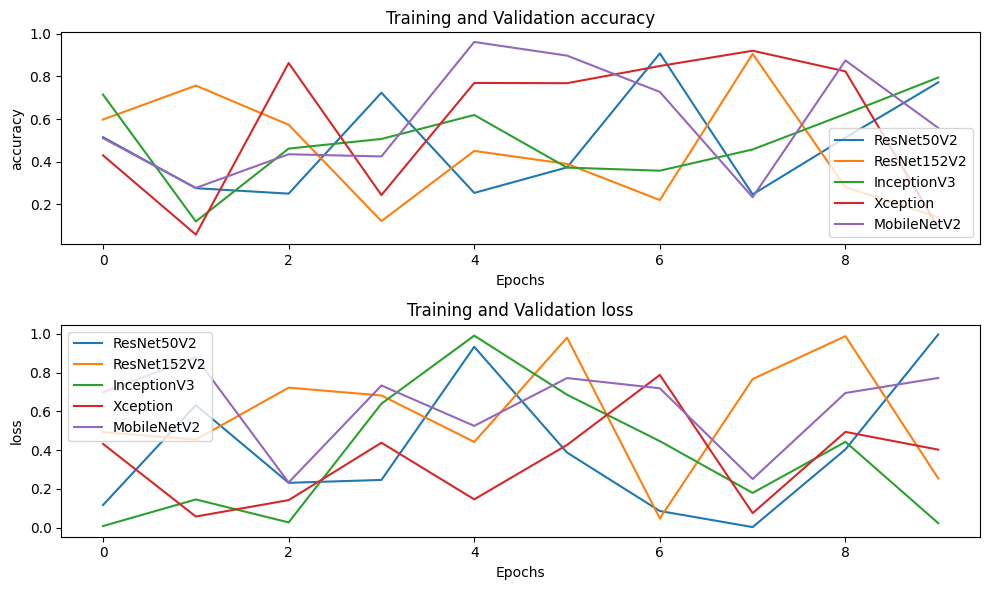

In [16]:
import matplotlib.pyplot as plt
import numpy as np


history_ResNet50V2 = {'accuracy': np.random.rand(10), 'loss': np.random.rand(10)}
history_ResNet152V2 = {'accuracy': np.random.rand(10), 'loss': np.random.rand(10)}
history_InceptionV3 = {'accuracy': np.random.rand(10), 'loss': np.random.rand(10)}
history_Xception = {'accuracy': np.random.rand(10), 'loss': np.random.rand(10)}
history_MobileNetV2 = {'accuracy': np.random.rand(10), 'loss': np.random.rand(10)}

TL_Models_NAMES = [
    'ResNet50V2',
    'ResNet152V2',
    'InceptionV3',
    'Xception',
    'MobileNetV2',
]

images_size = 224

TL_Models = [
    ResNet50V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    ResNet152V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    InceptionV3(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    Xception(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    MobileNetV2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
]

for tl_model in TL_Models:
    tl_model.trainable = False

metrics_to_plot = ['accuracy', 'loss']

fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 6))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 1, i+1)
    for idx, model in enumerate(TL_Models):
        plt.plot(eval(f'history_{TL_Models_NAMES[idx]}')[metric], label=TL_Models_NAMES[idx])
    plt.title(f'Training and Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()




### 5.1 Get the weights from DenseNet121

In [17]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(images_size, images_size, 3))

In [18]:
model = tf.keras.models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    
    layers.Flatten(),
    
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6,activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                        

###  Set the optimizer

In [19]:
from tensorflow.keras import optimizers

optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

In [20]:
model.compile(optimizer=optimizer,
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

###  Training the model

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=3,
    validation_data=test_generator,
    batch_size=batch_size,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[callback]
)

Epoch 1/3
 32/438 [=>............................] - ETA: 1:54:53 - loss: 1.7804 - accuracy: 0.2051

In [22]:
def build_model(hp):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(images_size, images_size, 3))
    
    model = keras.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    
    
    hp_learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')
    
    
    hp_dropout = hp.Float('dropout', min_value=0, max_value=0.8, step=0.1)
    
   
    hp_units = hp.Int('units', min_value=16, max_value=256, step=64)
    
    model.add(layers.Dropout(rate=hp_dropout))
    model.add(layers.Dense(units=hp_units, activation='relu'))
    model.add(layers.Dense(6, activation='softmax'))

    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [23]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5, 
    directory='keras_tuner_logs',
    project_name='xception_tuning'
)

In [24]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': 0.1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 64, 'sampling': 'linear'}


### Evaluate the testing

In [ ]:
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1/1 [==============================] - 4s 4s/step


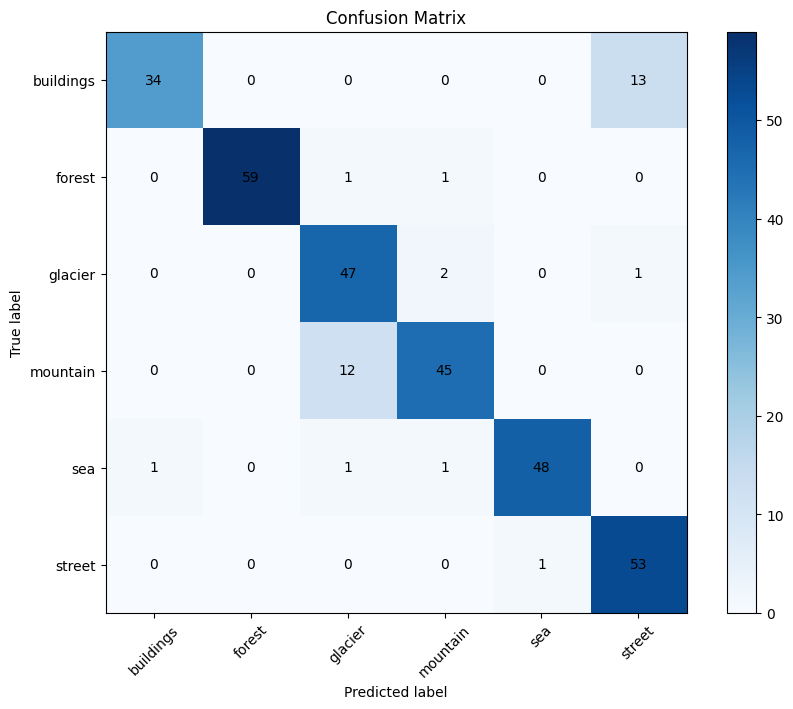

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

true_labels = []
predicted_labels = []

num_batches = 10
for i in range(num_batches):
    x_batch, y_batch = test_generator[i]
    predictions = model.predict(x_batch)
    true_labels.extend(np.argmax(y_batch, axis=1)) 
    predicted_labels.extend(np.argmax(predictions, axis=1))

class_names = test_generator.class_indices.keys()    

confusion = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(9, 7))

classes = [str(i) for i in range(len(test_generator.class_indices))]
plt.imshow(confusion, interpolation='nearest', cmap=plt.get_cmap('Blues'))


for i in range(len(classes)):
    for j in range(len(classes)):
        
        plt.text(j, i, str(confusion[i, j]), horizontalalignment='center', verticalalignment='center', color='black', fontsize=10)

plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [46]:

report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)

print(report)

              precision    recall  f1-score   support

   buildings       0.97      0.72      0.83        47
      forest       1.00      0.97      0.98        61
     glacier       0.77      0.94      0.85        50
    mountain       0.92      0.79      0.85        57
         sea       0.98      0.94      0.96        51
      street       0.79      0.98      0.88        54

    accuracy                           0.89       320
   macro avg       0.91      0.89      0.89       320
weighted avg       0.91      0.89      0.89       320

